# Bitcoin price prediction with LSTM

### Objective description

The objective of this notebook is to train a model that can beat the default Bitcoin investment strategy, which is buy and hold. This default strategy has its reasons: even if you bought BTC at the worst time in history, you only have to wait 4 years for your return to be positive. This becomes evident when viewing a plot of BTC on a logarithmic scale, and is based on fundamentals related to the adoption of the use of cryptocurrencies worldwide, its security, its scarcity, among others.

### Background and previous attempts

Several LSTM models were developed with different configurations and different preprocessing without success. Here it is only described the one that was successful. Below there is a summary of what was tried to justify the decisions made in the following code.

First, the objective was to predict if the next day the price will rise or fall. Many combinations of data were tested: using only close price, using all the prices, including or not the volume, including indicators like EMAs, DMI, RSI and including information about the date. Also the same combinations were tested on the output side: predicting only the close price, all the prices, etc. Also, the model was trained as a regressor using L1, L2 and SmoothL1 losses and as a classifier using CrossEntropy and Focal losses. 

It happens that all combinations were successful in the training set but always struggle to generalize to the validation/test set. Many techniques were implemented to prevent overfitting: using weight decay, training the model for both regression and classification, reducing the model size by reducing the dimensionality of states, using smooth labeling to prevent overconfidence in classification and using more data by using a hourly time frame instead of a daily timeframe, but neither one solved the problem. 

When studying the output of the model vs the dimensionality of states it was seen that decreasing the dimensionality has an effect similar to applying a low pass filter to the output. Considering that the input data is not the price itself, but the relative change between days ([here](https://www.youtube.com/watch?v=aIklUbW0UWI) it is explained why) and that this signal has a lot of high frequency components, there is a trade-off between overfitting and model capacity of predicting high-frequency signals. For this reason, the target was modified to be the weekly return instead of being the daily return. The weekly return has lower high-frequency components: the change from Monday to Monday is similar to the change from Tuesday to Tuesday, it's like averaging the target. This last target modification was successful, and is the one that was implemented on this notebook.

### Trading strategy

To compare the predictions of the model with the holding strategy, a trading strategy based on the predictions was defined. Considering that each day the model will predict if the price will raise or fall from that day to the same day of next week, the strategy was the folloing.

The initial capital in USD will be divided by 7, one part for each day of the week. Each day the trading bot is going to operate according to the following rules:

| Position | Prediction |  Action |
| -------- | ---------- | ------- |
|   USD    |    Rise    |   Buy   |
|   USD    |    Fall    | Nothing |
|   BTC    |    Rise    | Nothing |
|   BTC    |    Fall    |   Sell  |

In [177]:
import mplfinance as mpf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Parameter
import pandas as pd
import pandas_ta as ta
import numpy as np
from datetime import datetime
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import sliding_window_view
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import median_abs_deviation
import random
import os
import json

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

# 1. Read BTC/USD data

This CSV file was created with the download_bitstamp_data.py, which download BTC historic data from Bitstamp using the API via html requests

In [151]:
df = pd.read_csv('btcusd_1d_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df = df.rename(columns={'timestamp': 'datetime'})
df = df.set_index('datetime')
df = df.iloc[::-1] # reverse

In [152]:
print(df.shape)
print(df.isnull().sum())
df

(3843, 5)
open      0
high      0
low       0
close     0
volume    0
dtype: int64


,open,high,low,close,volume
datetime,,,,,
2011-08-18,10.90,10.90,10.90,10.90,0.489908
2011-08-19,11.85,11.85,11.15,11.69,1.926578
2011-08-20,11.70,11.70,11.70,11.70,0.085470
2011-08-21,11.70,11.70,11.70,11.70,0.085470
2011-08-22,11.70,11.70,11.70,11.70,0.028632
...,...,...,...,...,...
2022-02-19,40008.75,40471.27,39587.08,40109.02,695.654296
2022-02-20,40108.62,40151.62,37974.18,38373.90,1283.511547
2022-02-21,38384.09,39494.11,36810.72,37076.60,3501.420364


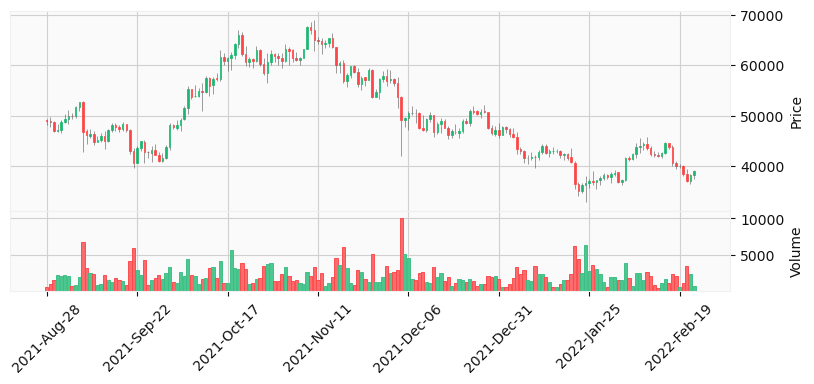

In [153]:
mpf.plot(df.iloc[-180:,:], type='candle', style='yahoo', volume=True, figsize=(10,4))

# 2. Data preprocessing and exploratory analysis

The idea is to explore some aspects of the data, like if the data is complete, how the variance (volatility of prices) changes over time, or if price returns have seasonal behaviour. Also, make the necessary preprocessing to make the data appropriate for a neural network model.

## 2.1. Missing data
Starts by analyzing if there are missing days or days without operated volume

In [154]:
print('Are there non-consecutive datetimes?:', any(df.index[1:] - df.index[:-1] > pd.Timedelta(1, 'd')))

Are there non-consecutive datetimes?: False


In [155]:
sum(df.volume == 0)

33

In [156]:
for year in range(2011, 2022+1):
    is_zero = df[np.logical_and(df.index >= datetime(year,1,1), df.index < datetime(year+1,1,1))].volume == 0
    print('Year ' + str(year) + ':', str(sum(is_zero)) + '/' + str(len(is_zero)), 'days with 0 volume')

Year 2011: 30/136 days with 0 volume
Year 2012: 0/366 days with 0 volume
Year 2013: 0/365 days with 0 volume
Year 2014: 0/365 days with 0 volume
Year 2015: 3/365 days with 0 volume
Year 2016: 0/366 days with 0 volume
Year 2017: 0/365 days with 0 volume
Year 2018: 0/365 days with 0 volume
Year 2019: 0/365 days with 0 volume
Year 2020: 0/366 days with 0 volume
Year 2021: 0/365 days with 0 volume
Year 2022: 0/54 days with 0 volume


In [157]:
years  = [2011,2011,2011,2011,2011]
months = [8,   9,   10,  11,  12]
for year, month in zip(years, months):
    next_year  = year + 1 if month == 12 else year
    next_month =    1     if month == 12 else month + 1
    is_zero = df[np.logical_and(df.index >= datetime(year,month,1), df.index < datetime(next_year,next_month,1))].volume == 0
    print('Year '+str(year)+' - Month '+str(month)+':', 
          str(sum(is_zero))+'/'+str(len(is_zero))+' ('+str(int(sum(is_zero)/len(is_zero)*100))+'%) days with 0 volume')

Year 2011 - Month 8: 6/14 (42%) days with 0 volume
Year 2011 - Month 9: 7/30 (23%) days with 0 volume
Year 2011 - Month 10: 9/31 (29%) days with 0 volume
Year 2011 - Month 11: 5/30 (16%) days with 0 volume
Year 2011 - Month 12: 3/31 (9%) days with 0 volume


There are 33 days without operated volume, and most of them are in 2011. In that time, the crypto market was very small and probably its behaviour is different from now. Maybe it would be beneficial to remove these samples, but they will be removed after when calculating some metrics.

## 2.2. Indicators

Due to the fact that the model has to be small to avoid overfitting, the input can't be so long because the model doesn't have the capacity to memorize very long sequences. This shrinks the capacity of the model to know at which relative position the current day is with respect to long-term trends. To help the model in this task, some Exponential Moving Averages (EMA) are added to the input. This is a very used indicator which traders use to make long-term decisions. Often, the length of the EMA is equal to the number of business days in a week, a month or a number of months. But as the crypto market operates all week days, here I will use 7, 30 and 180 days.

The EMA information will be calculated as the relative difference between the current close price and the EMA, taking the close price as refence. To calculate an EMA of N periods it is required N-1 previous samples, so here the first 179 samples will have no 180-EMA information and they will be removed. Remember that this period is almost all the data from 2011, which we mentioned that it has not so much information.

In [158]:
df_ema = pd.DataFrame({'ema7' : (ta.ema(df.close, length=6) - df.close)/df.close,
                       'ema30' : (ta.ema(df.close, length=12) - df.close)/df.close,
                       'ema180' : (ta.ema(df.close, length=24) - df.close)/df.close},
                      index=df.index)
df = pd.concat((df, df_ema), axis=1)
df = df.dropna()

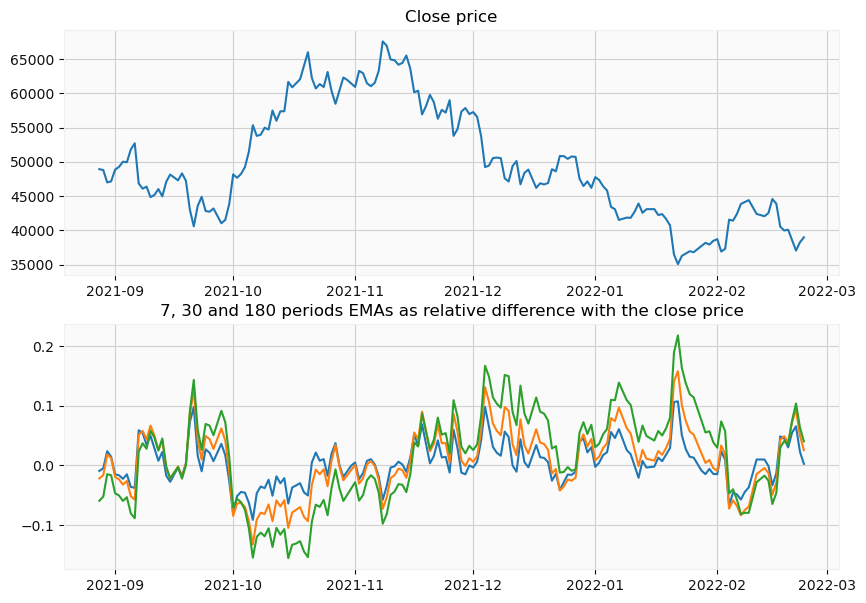

In [159]:
days = 180

fig, axes = plt.subplots(2, 1, figsize=(10,7))
axes[0].plot(df.close[-days:])
axes[0].set_title('Close price');
axes[1].plot(df.ema7[-days:])
axes[1].plot(df.ema30[-days:])
axes[1].plot(df.ema180[-days:])
axes[1].set_title('7, 30 and 180 periods EMAs as relative difference with the close price');

## 2.3. Stationarity

Here we will calculate the daily percentage return instead of the price for three reasons. The first reason is that the BTC price starts at \\$3 and it reaches all-time highs of >\\$60k, so the dynamic range is too high. If the data is normalized for example to a range of [0,1] the movements of the price in 2012 are negligible compared to 2021. The second reason is that most Deep Learning architectures struggle to extrapolate data beyond the range it was trained. And the third reason is that Sequence-based models works better with stationary or almost stationary data, and the best way to make the input data stationary is to calculate relative returns instead of absolute prices [[ref](https://www.youtube.com/watch?v=aIklUbW0UWI)].

The relative difference will be calculated with the next equation: $x_r[n] = (x[n+1] - x[n])/x[n]$.

To predict the price 7 days ahead, the target will be the difference between the current day and 8 days ahead. To make this clear let me put an example: If today is Monday, once the price closes and I have all the Monday prices (open, high, low and close) I will calculate the relative diferences to feed the model. So the last value I will have is the following:

$x_r[\text{Sunday}] = (x[\text{Monday}] - x[\text{Sunday}])/x[\text{Sunday}]$

and the predicted target value will be:

$x_t[\text{Sunday}] = (x[\text{Monday of next week}] - x[\text{Sunday}])/x[\text{Sunday}]$

which it has an 8-days difference.

In [160]:
di = 1
dt = 8

close_return = (df['close'][di:-dt+di].values - df['close'][:-dt].values)/df['close'][:-dt].values
low_return = (df['low'][di:-dt+di].values - df['low'][:-dt].values)/df['low'][:-dt].values
high_return = (df['high'][di:-dt+di].values - df['high'][:-dt].values)/df['high'][:-dt].values
open_return = (df['open'][di:-dt+di].values - df['open'][:-dt].values)/df['open'][:-dt].values
target = (df['close'][dt:].values - df['close'][:-dt].values)/df['close'][:-dt].values
volume = df['volume'][:-dt].values
ema7 = df['ema7'][:-dt].values
ema30 = df['ema30'][:-dt].values
ema180 = df['ema180'][:-dt].values

df_orig = df[:-dt].copy()

df = pd.DataFrame({'open': open_return, 'high': high_return, 'low': low_return, 'close': close_return, 'volume': volume,
                   'ema7': ema7, 'ema30': ema30, 'ema180': ema180, 'target': target}, index=df.index[:-dt])

For the volume it makes no sense to calculate the daily change. Instead, it is more useful to study it's distribution to properly normalize it:

<AxesSubplot:ylabel='Frequency'>

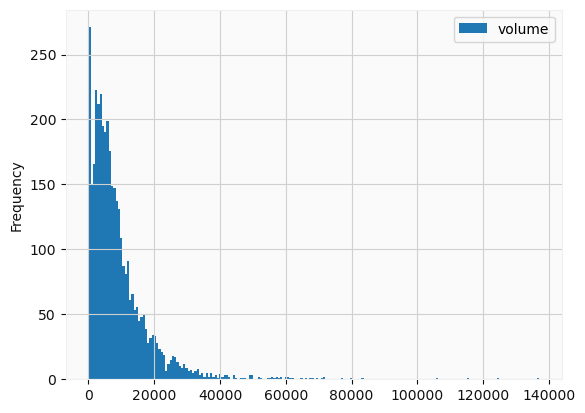

In [161]:
df[['volume']].plot.hist(bins=200)

It seems to be a log-normal distribution. To calculate the logarithm there must not be zero volume days, so I decide to remove them (there are only 3 remaining zero volume days in 2015).

In [162]:
df = df.drop(labels=df.index[np.where(df.volume==0)[0]], axis=0)

<AxesSubplot:ylabel='Frequency'>

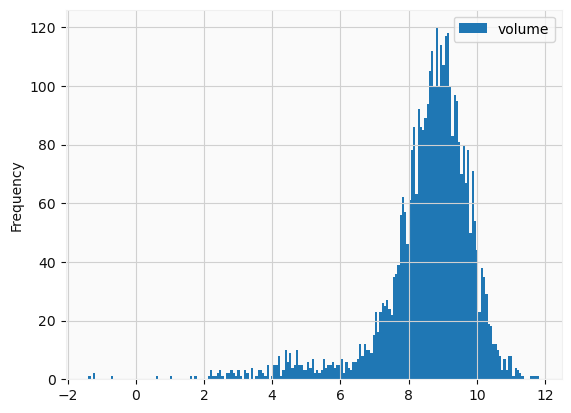

In [163]:
np.log(df[['volume']]).plot.hist(bins=200)

Effectively, it seems pretty normal. This value will have information about how much volume it was operated with respect to the historical operated volume.

In [164]:
volume_idx = list(df.columns).index('volume')
df.iloc[:,volume_idx] = np.log(df.iloc[:,volume_idx])

## 2.4. Seasonality

To analyze the seasonality the relative return of close price will be plotted vs the weekday, vs the day of month and vs the month of year

Text(0.5, 1.0, 'Means')

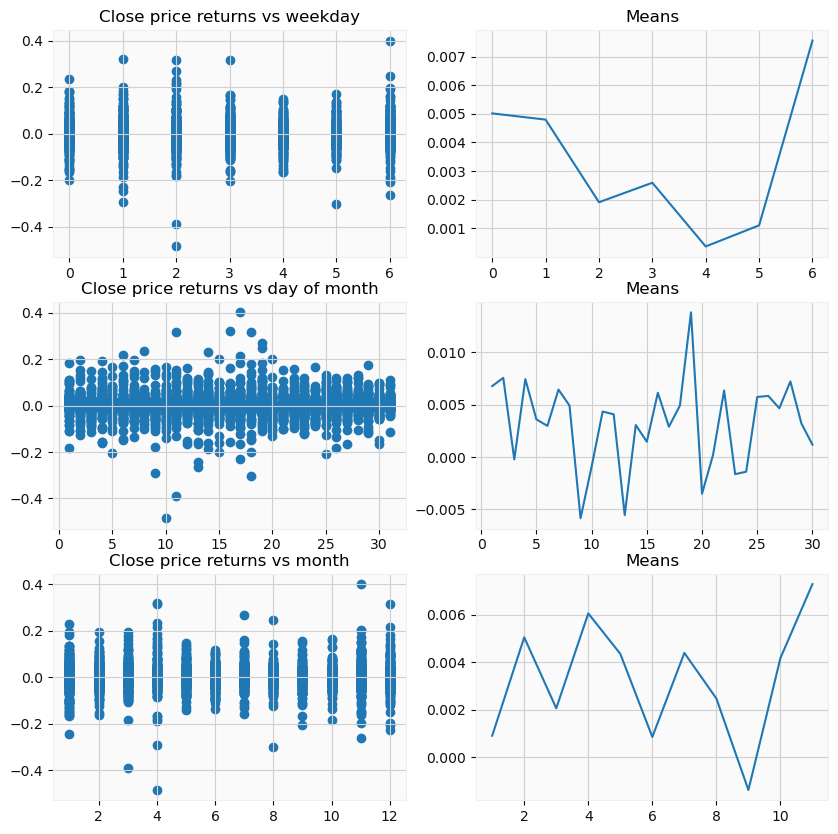

In [165]:
fig, axes = plt.subplots(3, 2, figsize=(10,10))
weekdays = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S').weekday
axes[0,0].scatter(weekdays, df.close)
means = [np.mean(df.close[df.index[weekdays == day]]) for day in range(7)]
axes[0,1].plot(range(7), means)
days = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S').day
axes[0,0].set_title('Close price returns vs weekday')
axes[0,1].set_title('Means')
axes[1,0].scatter(days, df.close)
means = [np.mean(df.close[df.index[days == day]]) for day in range(31)]
axes[1,1].plot(range(31), means)
axes[1,0].set_title('Close price returns vs day of month')
axes[1,1].set_title('Means')
months = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S').month
axes[2,0].scatter(months, df.close)
means = [np.mean(df.close[df.index[months == month]]) for month in range(12)]
axes[2,1].plot(range(12), means)
axes[2,0].set_title('Close price returns vs month')
axes[2,1].set_title('Means')

As can be seen, there is some dependency of the relative daily return vs the time, at least with respect to the weekday and the month. Including this information in the input of the model might help to improve the performance.

In [166]:
df['day'] = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S').day
df['weekday'] = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S').weekday
df['month'] = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S').month

## 2.5. Standarization / normalization

To feed the values to a neural network it is beneficial to standardize the values to mean=0, std=1 if the values have a normal distribution or to [0,1] or [-1,1] if the values have a uniform distribution or a predefined range like images. In this case, daily returns, EMAs and volume will be standardized and time variables will be normalized to [0,1]

In [167]:
std_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
df_price = pd.DataFrame(std_scaler.fit_transform(df[df.columns[:-3]].values), index=df.index, columns=df.columns[:-3])
df_days = pd.DataFrame(min_max_scaler.fit_transform(df[df.columns[-3:]].values), index=df.index, columns=df.columns[-3:])
dfn = pd.concat((df_days, df_price), axis=1)

# Clip values to 0.1% and 99.9%
for col in range(3, len(df.columns)):
    dfn.iloc[:,col] = np.clip(dfn.iloc[:,col], np.percentile(dfn.iloc[:,col], 0.1), np.percentile(dfn.iloc[:,col], 99.9)) 
    
dfn

,day,weekday,month,open,high,low,close,volume,ema7,ema30,ema180,target
datetime,,,,,,,,,,,,
2011-09-13,0.400000,0.166667,0.727273,-0.884277,-0.646904,-0.505480,-1.673947,-3.253488,3.984819,4.034182,4.477971,-0.572258
2011-09-14,0.433333,0.333333,0.727273,-1.832281,-1.123264,-1.841001,-1.644196,-3.219816,4.215030,4.571020,5.093112,0.041878
2011-09-15,0.466667,0.500000,0.727273,-1.324402,-0.953109,-0.824215,-1.258446,-3.023667,4.365222,5.037768,5.683849,0.615922
2011-09-16,0.500000,0.666667,0.727273,0.144632,-0.050113,0.199708,0.017215,-3.529089,4.131536,5.155168,5.887168,1.015391
2011-09-17,0.533333,0.833333,0.727273,-0.076328,0.081184,-0.304975,0.150708,-5.949239,2.898040,4.312085,5.474654,1.521919
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-11,0.333333,0.666667,0.090909,-0.637912,-0.322263,-0.182463,-0.156986,-0.631725,0.260184,-0.101057,-0.139732,-0.588232
2022-02-12,0.366667,0.833333,0.090909,-0.156490,-0.125713,-0.009826,-0.156437,-1.276176,0.258970,-0.029983,-0.089218,-0.854289
2022-02-13,0.400000,1.000000,0.090909,-0.154075,-0.022587,-0.211604,0.166485,-1.674101,0.257735,0.030114,-0.042765,-1.048626


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:ylabel='Frequency'>

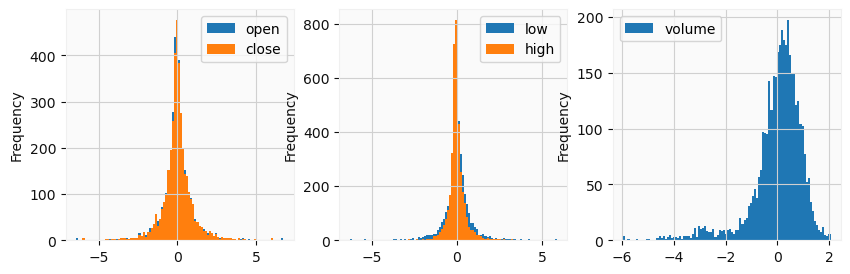

In [168]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
dfn[['open','close']].plot.hist(bins=100, ax=axes[0])
dfn[['low','high']].plot.hist(bins=100, ax=axes[1])
dfn[['volume']].plot.hist(bins=100, ax=axes[2])

# 3. Dataset and model class definitions

First I define a simple dataset class that takes a Pandas dataframe and outputs a PyTorch tensor with the data and other with the target. The user can select the window size for the data and the name of the target feature.

The class concat_datasets receives a list of datasets and merges into a single one.

In [169]:
class price_dataset(torch.utils.data.Dataset):
    def __init__(self, data, window_size, target_feature=None):
        super().__init__()
        self.data = data
        self.ws = window_size
        self.data_features = [col for col in data.columns if col != target_feature]
        self.target_feature = target_feature
        
    def __getitem__(self, item):
        if item >= len(self):
            raise IndexError
        
        data = torch.tensor(self.data[self.data_features].iloc[item:item+self.ws,:].values, dtype=torch.float32)
        target = torch.tensor(self.data[[self.target_feature]].iloc[item+self.ws-1], dtype=torch.float32)
        return data, target

    def __len__(self):
        return self.data.shape[0] - self.ws + 1
    
class concat_datasets(torch.utils.data.Dataset):
    def __init__(self, datasets):
        super().__init__()
        self.datasets = datasets
        self.lengths = [len(d) for d in datasets]
        
    def __getitem__(self, item):
        for i in range(len(self.lengths)):
            if item < sum(self.lengths[:i+1]):
                break
        return self.datasets[i][item-sum(self.lengths[:i])]

    def __len__(self):
        return sum(self.lengths)

The following is a metric that calculates the ideal gain that a trader can do with the prediction of the model if she/he opens a long position when the predicted direction of the price is rise and a short position when the predicted direction is fall. The objective is to have a metric that takes into account not only the accuracy of the movement predictions, but also the size of the movement. The accuracy by itself it is not so useful because if you have a 60% accuracy but the 40% you are missing are the most relevant movements, you may be losing money.

In [170]:
def trading_gain(direction_pred, direction, price_return):
    correct_dir = direction_pred == direction
    gain = torch.mean(correct_dir*torch.abs(price_return) - torch.logical_not(correct_dir)*torch.abs(price_return))
    return gain

Below are 3 definitions: First, a LSTMCell is defined based on the source code of LSTMCell of PyTorch ([source](https://github.com/pytorch/pytorch/blob/master/benchmarks/fastrnns/custom_lstms.py)). Secondly, the model itself made by a LSTMCell and a fully connected layer, and finally a PyTorch Lightning system to simplify the training task and training/testing logging.

In [178]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.weight_ih = Parameter(torch.randn(4 * hidden_size, input_size))
        self.weight_hh = Parameter(torch.randn(4 * hidden_size, hidden_size))
        self.bias_ih = Parameter(torch.randn(4 * hidden_size))
        self.bias_hh = Parameter(torch.randn(4 * hidden_size))

    def forward(self, input, state):
        hx, cx = state
        gates = (torch.mm(input, self.weight_ih.t()) + self.bias_ih +
                 torch.mm(hx, self.weight_hh.t()) + self.bias_hh)
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(forgetgate)
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)

        cy = (forgetgate * cx) + (ingate * cellgate)
        hy = outgate * torch.tanh(cy)

        return hy, cy
    
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = LSTMCell(input_size, hidden_size)
        self.fc = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.permute(x, (1, 0, 2))
        seq_length, batch_size, input_size = x.size()
        h = torch.zeros(batch_size, self.hidden_size)
        c = torch.zeros(batch_size, self.hidden_size)
        
        for xi in x.split(1, dim=0):
            xi = xi.squeeze(0)
            h, c = self.lstm(xi, (h, c))
            
        return self.fc(h)

class LSTM_pl(pl.LightningModule):
    def __init__(self, input_size=14, hidden_size=2, output_size=1):
        super().__init__()
        self.model = LSTM(input_size, hidden_size, output_size)
        self.criterion = torch.nn.SmoothL1Loss()
        
    def forward(self, batch):
        data, target = batch
        return self.model(data)
    
    def step(self, batch, step_name, return_loss=False):
        price = batch[1]
        direction = ((torch.sign(price) + 1)/2).long().squeeze()
        price_pred = self(batch)
        loss = self.criterion(price_pred, price)
        direction_acc = (torch.sign(price) == torch.sign(price_pred)).sum()/price.numel()
        gain = trading_gain(((torch.sign(price_pred) + 1)/2).long().squeeze(), direction, price)
        self.log('loss', {step_name: loss}, on_step=False, on_epoch=True)
        self.log('direction_acc', {step_name: direction_acc}, on_step=False, on_epoch=True)
        self.log('trading_gain', {step_name: gain}, on_step=False, on_epoch=True)
        if return_loss:
            return loss
        
    def training_step(self, batch, batch_idx):
        return self.step(batch, 'train', True)
            
    def validation_step(self, batch, batch_idx):
        return self.step(batch, 'valid', False)
                
    def test_step(self, batch, batch_idx):
        return self.step(batch, 'test', False)
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=hyperparams['learning_rate'])

# 4. Training

Use tensorboard to track the losses and metrics

In [12]:
%load_ext tensorboard
%tensorboard --logdir_spec=proyecto:lightning_logs,VM:C:/Users/Gastón/Desktop/Gaston/ViewMind/repos/raw_data_analysis/lightning_logs

Below is the training loop. As said at the beginning of the notebook, here we use K-Fold Cross Validation to see if the model performs well in all the Bitcoin history. In each fold, the model is first trained and then is tested on the validation set with a simulation of the trading strategy mentioned at the beginning of the notebook. 

When the validation set is in the middle of the historic data there are two training sets, one before and one after the validation set. These two sets are merged with the concat_datasets class.

Results are stored in a dictionary that can be saved into a JSON file in the next cell.

In [179]:
hyperparams = {'epochs'       : 100,
               'num_folds'    : 10,
               'learning_rate': 1e-3,
               'window_size'  : 14,
               'batch_size'   : 50,
               'hidden_size'  : 1}

results = {'hyperparams': hyperparams,
           'results': []}

num_samples = dfn.shape[0] - hyperparams['window_size']
fold_size = int(num_samples/hyperparams['num_folds'])

for fold_idx in range(hyperparams['num_folds']):
    df_valid = dfn.iloc[fold_size*fold_idx : fold_size*(fold_idx + 1) + hyperparams['window_size']]
    df_train1 = dfn.iloc[:fold_size*fold_idx + hyperparams['window_size']]
    df_train2 = dfn.iloc[fold_size*(fold_idx + 1):]
    
    first_pred_day = df_valid.index[0+hyperparams['window_size']]
    last_pred_day = df_valid.index[-1]
    result = {'fold_idx'      : fold_idx,
              'first_pred_day': str(first_pred_day.to_pydatetime()), 
              'last_pred_day' : str(last_pred_day.to_pydatetime())}
    print('Valid set:', first_pred_day, '-', last_pred_day, '-', df_valid.shape[0]-hyperparams['window_size'], 'days')
    print('Train set 1:', df_train1.index[hyperparams['window_size']-1], '-', df_train1.index[-1], '-', df_train1.shape[0]-hyperparams['window_size'], 'days')
    print('Train set 2:', df_train2.index[hyperparams['window_size']], '-', df_train2.index[-1], '-', df_train2.shape[0]-hyperparams['window_size'], 'days')
    
    valid_set = price_dataset(df_valid, window_size=hyperparams['window_size'], target_feature='target')
    if fold_idx == 0:
        train_set = price_dataset(df_train2, window_size=hyperparams['window_size'], target_feature='target')
    elif fold_idx == hyperparams['num_folds'] - 1:
        train_set = price_dataset(df_train1, window_size=hyperparams['window_size'], target_feature='target')
    else:
        train_set1 = price_dataset(df_train1, window_size=hyperparams['window_size'], target_feature='target')
        train_set2 = price_dataset(df_train2, window_size=hyperparams['window_size'], target_feature='target')
        train_set = concat_datasets([train_set1, train_set2])

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=hyperparams['batch_size'], shuffle=True, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=1, shuffle=False)
    
    model = LSTM_pl(input_size=11, hidden_size=hyperparams['hidden_size'], output_size=1)
    trainer = pl.Trainer(gpus=0, precision=32, max_epochs=hyperparams['epochs'])
    trainer.fit(model, train_loader, valid_loader)
    
    # Predict prices
    price_list = []
    ret_list = []
    ret_pred_list = []
    orig_set = price_dataset(df_orig.loc[df_valid.index], window_size=hyperparams['window_size'], target_feature='close')
    for batch, (_, price) in zip(valid_loader, orig_set):
        ret_pred = model(batch)
        price_list.append(price)
        ret_list.append(batch[1].squeeze().detach().item())
        ret_pred_list.append(ret_pred.squeeze().detach().item())

    # Apply inverse normalization
    price = np.array(price_list)
    ret_norm = np.array(ret_list)
    ret_pred_norm = np.array(ret_pred_list)
    ret = std_scaler.inverse_transform(np.repeat(ret_norm[:,np.newaxis], 9, axis=1))[:,-1]
    ret_pred = std_scaler.inverse_transform(np.repeat(ret_pred_norm[:,np.newaxis], 9, axis=1))[:,-1]
    
    # Trading bot simulation
    capital_usd = 1000
    capital_usd_holding = capital_usd/price[0]*price[-1]
    capital_usd_trading = [capital_usd/7 for _ in range(7)]
    capital_btc_trading = [0]*7

    for i in range(len(valid_set)):
        pred = ret_pred[i]
        weekday = i % 7
        if pred > 0:
            if capital_usd_trading[weekday] > 0:
                capital_btc_trading[weekday] = capital_usd_trading[weekday]/price[i]
                capital_usd_trading[weekday] = 0
        else:
            if capital_btc_trading[weekday] > 0:
                capital_usd_trading[weekday] = capital_btc_trading[weekday]*price[i]
                capital_btc_trading[weekday] = 0

    # Sell remaining BTC
    for weekday in range(7):
        if capital_btc_trading[weekday] > 0:
            capital_usd_trading[weekday] = capital_btc_trading[weekday]*price[-1]
            capital_btc_trading[weekday] = 0
            
    holding_gain_ = capital_usd_holding/capital_usd
    trading_gain_ = sum(capital_usd_trading)/capital_usd
    holding_gain_ = holding_gain_.item() if isinstance(holding_gain_, torch.Tensor) else holding_gain_
    trading_gain_ = trading_gain_.item() if isinstance(trading_gain_, torch.Tensor) else trading_gain_
    result['holding_gain'] = holding_gain_
    result['trading_gain'] = trading_gain_
    print('Holding gain:', str(np.round(100*holding_gain_, 3)) + '%')
    print('Trading gain:', str(np.round(100*trading_gain_, 3)) + '%')
    print('')
    
    results['results'].append(result)

Valid set: 2011-09-27 00:00:00 - 2012-10-25 00:00:00 - 377 days
Train set 1: 2011-09-26 00:00:00 - 2011-09-26 00:00:00 - 0 days
Train set 2: 2012-10-26 00:00:00 - 2022-02-15 00:00:00 - 3397 days


Validation sanity check: 0it [00:00, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Holding gain: 219.792%
Trading gain: 357.548%

Valid set: 2012-10-26 00:00:00 - 2013-11-06 00:00:00 - 377 days
Train set 1: 2011-09-26 00:00:00 - 2012-10-25 00:00:00 - 377 days
Train set 2: 2013-11-07 00:00:00 - 2022-02-15 00:00:00 - 3020 days


C:\Users\GASTN~1\AppData\Local\Temp/ipykernel_12476/410807199.py:57: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  price = np.array(price_list)
C:\Users\GASTN~1\AppData\Local\Temp/ipykernel_12476/410807199.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  price = np.array(price_list)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Holding gain: 2495.166%
Trading gain: 3526.673%

Valid set: 2013-11-07 00:00:00 - 2014-11-18 00:00:00 - 377 days
Train set 1: 2011-09-26 00:00:00 - 2013-11-06 00:00:00 - 754 days
Train set 2: 2014-11-19 00:00:00 - 2022-02-15 00:00:00 - 2643 days


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Holding gain: 142.41%
Trading gain: 448.235%

Valid set: 2014-11-19 00:00:00 - 2015-12-03 00:00:00 - 377 days
Train set 1: 2011-09-26 00:00:00 - 2014-11-18 00:00:00 - 1131 days
Train set 2: 2015-12-04 00:00:00 - 2022-02-15 00:00:00 - 2266 days


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Holding gain: 96.41%
Trading gain: 208.671%

Valid set: 2015-12-04 00:00:00 - 2016-12-14 00:00:00 - 377 days
Train set 1: 2011-09-26 00:00:00 - 2015-12-03 00:00:00 - 1508 days
Train set 2: 2016-12-15 00:00:00 - 2022-02-15 00:00:00 - 1889 days


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Holding gain: 215.01%
Trading gain: 226.122%

Valid set: 2016-12-15 00:00:00 - 2017-12-26 00:00:00 - 377 days
Train set 1: 2011-09-26 00:00:00 - 2016-12-14 00:00:00 - 1885 days
Train set 2: 2017-12-27 00:00:00 - 2022-02-15 00:00:00 - 1512 days


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Holding gain: 2028.65%
Trading gain: 2356.967%

Valid set: 2017-12-27 00:00:00 - 2019-01-07 00:00:00 - 377 days
Train set 1: 2011-09-26 00:00:00 - 2017-12-26 00:00:00 - 2262 days
Train set 2: 2019-01-08 00:00:00 - 2022-02-15 00:00:00 - 1135 days


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Holding gain: 25.408%
Trading gain: 124.6%

Valid set: 2019-01-08 00:00:00 - 2020-01-19 00:00:00 - 377 days
Train set 1: 2011-09-26 00:00:00 - 2019-01-07 00:00:00 - 2639 days
Train set 2: 2020-01-20 00:00:00 - 2022-02-15 00:00:00 - 758 days


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Holding gain: 217.119%
Trading gain: 329.502%

Valid set: 2020-01-20 00:00:00 - 2021-01-30 00:00:00 - 377 days
Train set 1: 2011-09-26 00:00:00 - 2020-01-19 00:00:00 - 3016 days
Train set 2: 2021-01-31 00:00:00 - 2022-02-15 00:00:00 - 381 days


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Holding gain: 394.671%
Trading gain: 637.348%

Valid set: 2021-01-31 00:00:00 - 2022-02-11 00:00:00 - 377 days
Train set 1: 2011-09-26 00:00:00 - 2021-01-30 00:00:00 - 3393 days
Train set 2: 2022-02-12 00:00:00 - 2022-02-15 00:00:00 - 4 days


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Holding gain: 123.55%
Trading gain: 208.032%



In [180]:
# Save results
json_dir = 'results'
file_name = 'final_20220301.json'

try:
    os.makedirs(json_dir)
except FileExistsError:
    pass

json_filename = os.path.normpath(os.path.join(json_dir, file_name))
if os.path.exists(json_filename):
    print('Error: file exists')
else:
    with open(json_filename, 'w') as fid:
        json.dump(results, fid, indent=4)
    print('Done')

Done


Load a JSON file (if necessary)

In [ ]:
json_filename = 'results/final_20220301.json'
with open(json_filename, 'r') as fid:
    results = json.load(fid)

Plot the gain made with the trading strategy based on predictions vs the holding strategy

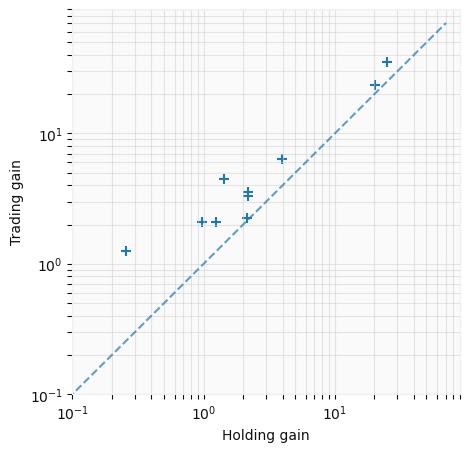

In [181]:
gain_holding = []
gain_trading = []
for res in results['results']:
    gain_holding.append(res['holding_gain'])
    gain_trading.append(res['trading_gain'])
    
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
plt.scatter(gain_holding, gain_trading, marker='+', s=50)
plt.plot([0, 2*max(gain_trading)], [0, 2*max(gain_trading)], '--', alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.grid(alpha=0.5)
plt.xlim([0.5*min(gain_holding), 1.2*max(gain_trading)])
plt.ylim([0.5*min(gain_holding), 1.2*max(gain_trading)])
plt.xlabel('Holding gain')
plt.ylabel('Trading gain')
ticks = list(np.arange(0.1, 1, 0.1))
ticks.extend(list(range(1, 10)))
ticks.extend(list(range(10, 100, 10)))
ax.set_xticks(ticks);
ax.set_yticks(ticks);

# Conclusion

As can be seen on the last plot, all the points that represent the result of each Cross Validation fold gives better results than just holding in the same period. This means that the Bitcoin price is at least a little predictable and that the objective was accomplished. To make this result more real, it should be included the spread cost and trading comissions in the simulation.

For future work there are two next steps to improve the performance of the model. First, more data should be included to the input, like information of other markets or sentiment analysis of news about Bitcoin. Secondly, as the trainable part of the model needs to be small to prevent overfitting, the capacity of the model to detect complex patters is really low. To improve on this, more indicators can be included on the input data in replacement of internal indicators that the model could have learned if it were more complex. For example, the number of days since the last maximum/minimum, indicators about the volume profile, momentum indicators, etc.